In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
projects_df = pd.read_csv("projects.csv", skipinitialspace=True)
deals_df = pd.read_csv("offers.csv", skipinitialspace=True, low_memory=False)

In [58]:
projects_df.head(2)

,ID корпуса,Проект,Класс проекта,Девелопер,Конструкця дома,Этажей от,Этожей до,Адрес,Плановая дата РВЭ,Стадия строительства,Тип договора реализации,Тип объекта недвижимости,Этаж,Кол-во комнат,Общая проектная площадь,Количество лотов
0,014d0676b7339e64e1bced5c91689519,Скандинавия,Комфорт,А101,Монолит-блоки,16,16,"Сосенское пос., д. 23, к. 23.1",2023-11-29,Введен в эксплуатацию,КП,квартира,2.0,1,92.3,3
1,014d0676b7339e64e1bced5c91689519,Скандинавия,Комфорт,А101,Монолит-блоки,16,16,"Сосенское пос., д. 23, к. 23.1",2023-11-29,Введен в эксплуатацию,КП,квартира,2.0,2,197.1,4


In [59]:
deals_df.head(2)

,Название региона,Город,Район,Округ,Класс,Конструкция объекта,Застройщик,Название ЖК,Адрес корпуса,ID корпуса,...,Этаж лота,Количество комнат,Суммарная площадь сделок,Сумма бюджета,Скидка,Внутренняя отделка,Продавец,Покупатель,Ипотека,Название банка
0,Новая Москва,Николо-Хованское дер.,НАО,Коммунарка,Комфорт,Монолит-блоки,А101,Прокшино,"Сосенское пос., кв-л 26, з/у 3/3, к. 10.1.5",002b4f20e97d6ca8ac349b5e2e9e81d3,...,5,1,36.10,13228050.80,без скидки,Под чистовую и отделка как доп. опция,ФЛ,ФЛ,Ипотека,ПАО Сбербанк России
1,Новая Москва,Николо-Хованское дер.,НАО,Коммунарка,Комфорт,Монолит-блоки,А101,Прокшино,"Сосенское пос., кв-л 26, з/у 3/3, к. 10.1.5",002b4f20e97d6ca8ac349b5e2e9e81d3,...,2,1,38.50,13007417.89,без скидки,Под чистовую и отделка как доп. опция,ЮЛ,ФЛ,Ипотека,ПАО Сбербанк России


Исправляем ошибки в названиях колонок

In [60]:
projects_df = projects_df.rename(columns={"Этожей до": "Этажей до", "Конструкця дома": "Конструкция дома"})

Приводим колонки к одному виду, чтобы было проще

In [61]:
projects_df.columns = projects_df.columns.str.lower().str.replace(" ", "_")
deals_df.columns = deals_df.columns.str.lower().str.replace(" ", "_")

В изначальном датасете перепутаны названия колонок, исправляем это

In [62]:
deals_cols = list(deals_df.columns)
deals_cols[deals_df.columns.get_loc("округ")] = "район"
deals_cols[deals_df.columns.get_loc("район")] = "округ"
deals_df.columns = deals_cols

In [63]:
projects_df["плановая_дата_рвэ"] = pd.to_datetime(projects_df["плановая_дата_рвэ"])
deals_df["дата_ввода_в_эксплуатацию"] = pd.to_datetime(deals_df["дата_ввода_в_эксплуатацию"])
deals_df["дата_договора_(месяц.год)"] = pd.to_datetime(deals_df["дата_договора_(месяц.год)"])
deals_df["дата_начала_продаж"] = pd.to_datetime(deals_df["дата_начала_продаж"])
deals_df["дата_регистрации_(месяц.год)"] = pd.to_datetime(deals_df["дата_регистрации_(месяц.год)"])

Проверим id в проектах и в сделках

In [64]:
ids_project = projects_df["id_корпуса"].unique()
ids_deals = deals_df["id_корпуса"].unique()
ids_project.size, ids_deals.size

(419, 420)

In [65]:
for i in range(len(ids_deals)):
    if ids_deals[i] not in ids_project:
        print(f"Prev to wrong id: {ids_deals[i - 1]}")
        print(f"Wrong id: {ids_deals[i]}")
        print(f"After wrong id: {ids_deals[i + 1]}")
        print("=" * 60)
    if i < ids_project.size and ids_project[i] not in ids_deals:
        print(f"Prev to wrong id: {ids_project[i - 1]}")
        print(f"Wrong id: {ids_project[i]}")
        print(f"After wrong id: {ids_project[i + 1]}")
        print("=" * 60)

Prev to wrong id: ad24c41ce17c6f05bb87db700b219f0a
Wrong id: ae7a9a11c75a4c2e124f7ff29a987068
After wrong id: afd82984da6e48910eead0538b200c02


Одного id нет в проектах, но есть в сделках, и это не опечатка

Приводим названия населенных пунктов к общему виду

In [66]:
def normalize_settlement_name(name):
    type_mapping = {
        'дер.': 'дер.',
        'КП': 'коттеджный пос.',
        'коттеджный пос.': 'коттеджный пос.',
        'дачный пос.': 'дачный пос.',
        'п.': 'пос.',
        'пос.': 'пос.',
        'СНТ': 'СНТ',
        'садовое товарищество': 'СНТ',
        'ТСН': 'ТСН',
        'село': 'с.',
        'с.': 'с.'
    }
    
    words = name.split()
    
    found_type = None
    other_words = []
    
    i = 0
    while i < len(words):
        current_word = words[i]
        
        if current_word in type_mapping:
            found_type = type_mapping[current_word]
            i += 1
            continue
            
        if i + 1 < len(words):
            two_words = f"{current_word} {words[i+1]}"
            if two_words in type_mapping:
                found_type = type_mapping[two_words]
                i += 2
                continue
        
        other_words.append(current_word)
        i += 1
    
    if found_type:
        return f"{found_type} {' '.join(other_words)}".strip()
    else:
        return name

deals_df["город"] = deals_df["город"].transform(lambda s: normalize_settlement_name(s))

In [67]:
wrong_vals = projects_df[~projects_df["общая_проектная_площадь"].str.replace(".", "", 1).str.isdigit()]["общая_проектная_площадь"]
projects_df.loc[wrong_vals.index, "общая_проектная_площадь"] = np.nan
projects_df["общая_проектная_площадь"] = projects_df["общая_проектная_площадь"].astype("float")

wrong_vals = deals_df[~deals_df["суммарная_площадь_сделок"].str.replace(".", "", 1).str.isdigit()]["суммарная_площадь_сделок"]
deals_df.loc[wrong_vals.index, "суммарная_площадь_сделок"] = np.nan
deals_df["суммарная_площадь_сделок"] = deals_df["суммарная_площадь_сделок"].astype("float")

Находим пропущенное значение в количестве комнат

In [68]:
deals_df[(deals_df["класс"] == "Комфорт") & (deals_df["город"] == "дер. Середнево")].groupby("количество_комнат").apply(lambda x: (x["суммарная_площадь_сделок"] / x["суммарное_количество_сделок"]).describe(), include_groups=False)

,count,mean,std,min,25%,50%,75%,max
количество_комнат,,,,,,,,
-,1.0,66.820000,NaN,66.82,66.82,66.82,66.82,66.82
1,959.0,36.048670,3.721210,26.90,33.50,35.60,39.10,50.30
2,772.0,56.947358,3.530163,49.15,56.45,56.70,57.80,68.47
3,219.0,70.991689,8.238506,55.20,64.90,74.20,75.20,92.44
4,3.0,99.200000,0.000000,99.20,99.20,99.20,99.20,99.20
ст,585.0,22.576154,2.207444,19.50,21.00,22.20,23.66,28.80


По полученным данным можно узнать, что пропущенное значение будет скорее всего равно 3

In [69]:
deals_df["количество_комнат"] = deals_df["количество_комнат"].replace("-", "3")

Общий анализ датасета

In [70]:
projects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21273 entries, 0 to 21272
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_корпуса                21273 non-null  object        
 1   проект                    21273 non-null  object        
 2   класс_проекта             21273 non-null  object        
 3   девелопер                 21273 non-null  object        
 4   конструкция_дома          21273 non-null  object        
 5   этажей_от                 21273 non-null  int64         
 6   этажей_до                 21273 non-null  int64         
 7   адрес                     21273 non-null  object        
 8   плановая_дата_рвэ         21273 non-null  datetime64[ns]
 9   стадия_строительства      21273 non-null  object        
 10  тип_договора_реализации   21273 non-null  object        
 11  тип_объекта_недвижимости  21273 non-null  object        
 12  этаж              

In [71]:
deals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50955 entries, 0 to 50954
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   название_региона              50955 non-null  object        
 1   город                         50955 non-null  object        
 2   округ                         50955 non-null  object        
 3   район                         50955 non-null  object        
 4   класс                         50955 non-null  object        
 5   конструкция_объекта           50955 non-null  object        
 6   застройщик                    50955 non-null  object        
 7   название_жк                   50955 non-null  object        
 8   адрес_корпуса                 50955 non-null  object        
 9   id_корпуса                    50955 non-null  object        
 10  текущая_стадия_строительства  50955 non-null  object        
 11  дата_начала_продаж          

Смотрим на наличие опечаток в строковых колонках

In [72]:
cm = sns.dark_palette("green", as_cmap=True)
for col in projects_df.select_dtypes("object").columns.drop(["id_корпуса", "адрес"]):
    display(projects_df[col].value_counts().reset_index().sort_values(col).reset_index(drop=True).style.background_gradient(cmap=cm))

,проект,count
0,1-й Саларьевский,497
1,1-й Ясеневский,159
2,Foreville,408
3,RDD / Russian Design District,182
4,Smart Garden,114
5,Академик,74
6,Аквилон Park,73
7,Алхимово,587
8,Баркли Медовая Долина,42
9,Бунинские кварталы,1488


,класс_проекта,count
0,Бизнес,182
1,Бизнес-,70
2,Комфорт,20825
3,Эконом,196


,девелопер,count
0,3S GROUP,408
1,Barkli,42
2,INGRAD,158
3,Plus Development,235
4,Sezar Group,70
5,Unikey,99
6,А101,8966
7,Абсолют Недвижимость,1672
8,Атлант,60
9,Выбор,74


,конструкция_дома,count
0,Монолит-блоки,17270
1,Монолит-блоки-кирпич,426
2,Монолит-кирпич,655
3,Монолит-панель,971
4,Монолит-панель-блоки,1951


,стадия_строительства,count
0,Введен в эксплуатацию,10552
1,Монтажные и отделочные работы,10431
2,"Получение РВЭ, благоустройство территории",21
3,Работы нулевого цикла,146
4,Строительство не начато,123


,тип_договора_реализации,count
0,ДДУ без эскроу,74
1,ДДУ с эскроу,13396
2,КП,6229
3,Предварительный КП,1501
4,Уступка прав от юрлица,73


,тип_объекта_недвижимости,count
0,апартаменты,135
1,квартира,20075
2,кладовка,600
3,машино-место,33
4,нежилое помещение,430


,кол-во_комнат,count
0,1,5788
1,2,5277
2,3,4905
3,4,1219
4,5,4
5,Без типа,925
6,ст,3017


In [73]:
for col in deals_df.select_dtypes("object").columns.drop(["id_корпуса", "адрес_корпуса"]):
    display(deals_df[col].value_counts().reset_index().sort_values(col).reset_index(drop=True).style.background_gradient(cmap=cm))

,название_региона,count
0,Новая Москва,50955


,город,count
0,Москва,1966
1,СНТ Ёлочка,539
2,СНТ Нефтемаш,345
3,ТСН Солнечный,180
4,Троицк,91
5,Щербинка,517
6,дачный пос. Кокошкино,730
7,дер. Алхимово,789
8,дер. Большое Свинорье,481
9,дер. Ватутинки,4


,округ,count
0,НАО,46372
1,ТАО,4583


,район,count
0,Внуково,6489
1,Коммунарка,27077
2,Троицк,4583
3,Филимонковский,6372
4,Щербинка,6434


,класс,count
0,Бизнес,7
1,Бизнес-,1016
2,Комфорт,48908
3,Эконом,1024


,конструкция_объекта,count
0,Монолит-блоки,39467
1,Монолит-блоки-кирпич,1474
2,Монолит-кирпич,336
3,Монолит-панель,1024
4,Монолит-панель-блоки,8654


,застройщик,count
0,3S GROUP,367
1,Barkli,4
2,INGRAD,133
3,Plus Development,337
4,Sezar Group,1016
5,Unikey,22
6,А101,19146
7,Абсолют Недвижимость,3111
8,Атлант,144
9,Выбор,52


,название_жк,count
0,1-й Саларьевский,290
1,1-й Ясеневский,736
2,Foreville,367
3,RDD / Russian Design District,7
4,Smart Garden,56
5,Академик,52
6,Аквилон Park,2
7,Алхимово,1820
8,Баркли Медовая Долина,4
9,Бунинские кварталы,3114


,текущая_стадия_строительства,count
0,Введен в эксплуатацию,993
1,Монтажные и отделочные работы,31936
2,Начало монтажных работ,3100
3,"Получение РВЭ, благоустройство территории",180
4,Работы нулевого цикла,10864
5,Строительство не начато,3882


,уступка,count
0,Договор уступки,1495
1,Договор участия,49460


,тип_лота,count
0,апартаменты,1055
1,квартира,49900


,количество_комнат,count
0,1,20475
1,2,14095
2,3,6316
3,4,504
4,ст,9565


,скидка,count
0,без скидки,20145
1,со скидкой,12076
2,со скидкой и без скидки,18734


,внутренняя_отделка,count
0,Без отделки,14175
1,Без отделки и отделка как доп. опция,28
2,"Без отделки, под чистовую и с отделкой",267
3,"Без отделки, под чистовую, с отделкой (с мебелью и без)",2
4,"Без отделки, под чистовую, с отделкой, мебель как доп. опция",1
5,"Без отделки, с отделкой (с мебелью и без)",7
6,"Без отделки, с отделкой и мебель как доп. опция",94
7,Отделка и мебель как доп. опция,1870
8,Отделка как доп. опция,292
9,Под чистовую,867


,продавец,count
0,ФЛ,695
1,ЮЛ,50260


,покупатель,count
0,ФЛ,50266
1,ЮЛ,689


,ипотека,count
0,Ипотека,41391
1,Нет,9564


,название_банка,count
0,OOO Московский ипотечный центр-МИЦ,3
1,OOO Яндекс,3
2,OOO Яндекс.Технологии,3
3,OOOА101,2
4,АКБ НОВИКОМБАНК АО,13
5,АО АБ РОССИЯ,72
6,АО Альфа-Банк,2925
7,АО БАНК АКЦЕПТ,1
8,АО Банк ДОМ.РФ,1867
9,АО Банк Жилищного Финансирования,96


Посмотрим на значения в колонках с датой

In [74]:
projects_df.select_dtypes("datetime").describe()

,плановая_дата_рвэ
count,21273
mean,2025-06-28 04:52:17.498236928
min,2021-06-21 00:00:00
25%,2024-09-20 00:00:00
50%,2025-12-30 00:00:00
75%,2026-03-31 00:00:00
max,2027-12-31 00:00:00


In [75]:
deals_df.select_dtypes("datetime").describe()

,дата_начала_продаж,дата_ввода_в_эксплуатацию,дата_договора_(месяц.год),дата_регистрации_(месяц.год)
count,50955,50955,50955,50955
mean,2023-02-02 21:26:32.817191680,2025-05-14 20:15:43.609067008,2024-01-02 06:33:58.551662848,2024-01-22 00:03:59.081542400
min,2008-10-01 00:00:00,2017-09-15 00:00:00,2019-07-01 00:00:00,2023-01-01 00:00:00
25%,2022-08-08 00:00:00,2024-12-31 00:00:00,2023-08-01 00:00:00,2023-09-01 00:00:00
50%,2023-02-06 00:00:00,2025-03-31 00:00:00,2024-01-01 00:00:00,2024-02-01 00:00:00
75%,2023-08-31 00:00:00,2025-12-31 00:00:00,2024-06-01 00:00:00,2024-07-01 00:00:00
max,2024-12-18 00:00:00,2027-12-31 00:00:00,2025-09-01 00:00:00,2024-12-01 00:00:00


In [76]:
deals_df[deals_df["дата_начала_продаж"] == pd.to_datetime("2008-10-01 00:00:00")].select_dtypes("datetime")

,дата_начала_продаж,дата_ввода_в_эксплуатацию,дата_договора_(месяц.год),дата_регистрации_(месяц.год)
37616,2008-10-01,2017-10-31,2024-07-01,2024-07-01


Никаких экстремальных значений не наблюдается

Сделаем поправку на инфляцию в колонке цены, используя как базисный месяц январь 2023

In [77]:
# ИПЦ: накопленный индекс относительно января 2023 (база = 100.0000)
# Источник: Росстат

cpi_data = {
    '2023-01-01': 100.0000,
    '2023-02-01': 100.4600,
    '2023-03-01': 100.8317,
    '2023-04-01': 101.2149,
    '2023-05-01': 101.5286,
    '2023-06-01': 101.9043,
    '2023-07-01': 102.5463,
    '2023-08-01': 102.8334,
    '2023-09-01': 103.7281,
    '2023-10-01': 104.5890,
    '2023-11-01': 105.7499,
    '2023-12-01': 106.5219,
    '2024-01-01': 107.4380,
    '2024-02-01': 108.1686,
    '2024-03-01': 108.5904,
    '2024-04-01': 109.1334,
    '2024-05-01': 109.9410,
    '2024-06-01': 110.6446,
    '2024-07-01': 111.9060,
    '2024-08-01': 112.1298,
    '2024-09-01': 112.6680,
    '2024-10-01': 113.5130,
    '2024-11-01': 115.1362,
    '2024-12-01': 116.6560,
}

cpi = pd.Series(cpi_data)
cpi.index = pd.to_datetime(cpi.index)

deals_df = deals_df.merge(cpi.rename('ипц').reset_index().rename(columns={'index': 'month'}), 
              left_on="дата_регистрации_(месяц.год)", right_on='month', how='left')

deals_df['реальная_сумма_бюджета'] = deals_df['сумма_бюджета'] * (100.0 / deals_df['ипц'])

Посмотрим на распределение числовых значений

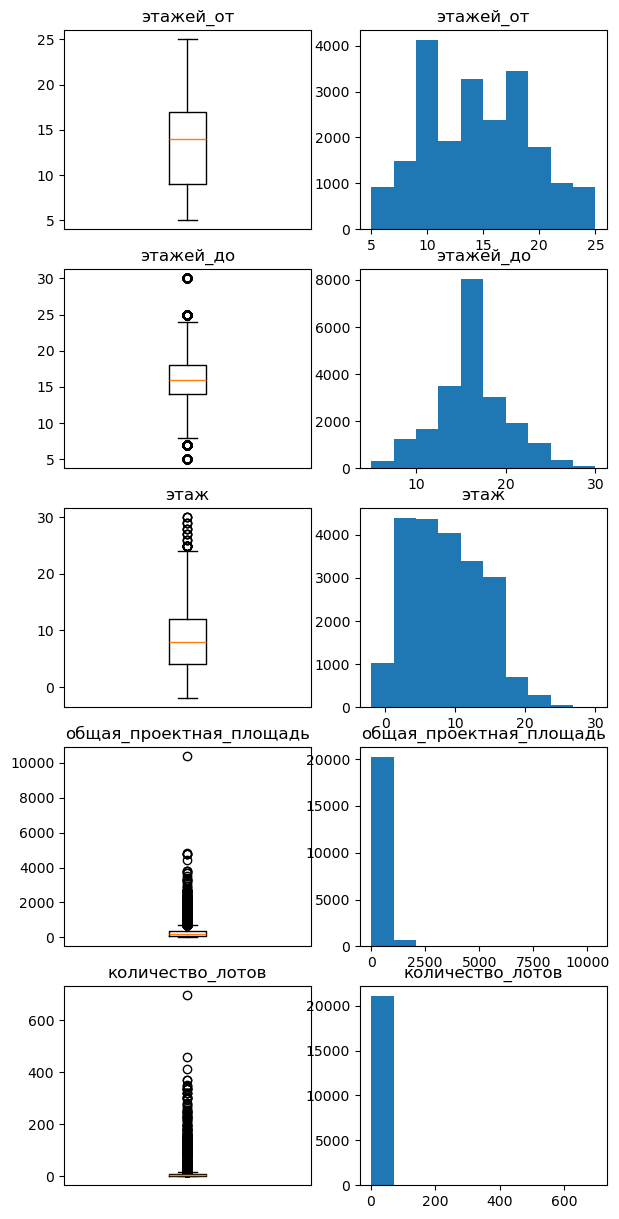

In [78]:
fig, axes = plt.subplots(projects_df.select_dtypes("number").columns.size, 2)
axes = axes.flatten()
fig.set_size_inches(7, 15)
num_cols = projects_df.select_dtypes("number").columns

for i in range(0, num_cols.size * 2, 2):
    axes[i].boxplot(projects_df[num_cols[i // 2]].dropna())
    axes[i + 1].hist(projects_df[num_cols[i // 2]])
    axes[i].set_title(num_cols[i // 2])
    axes[i + 1].set_title(num_cols[i // 2])
    axes[i].tick_params(
        axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False)


plt.show()

Посмотрим на значения, выбивающиеся из общей массы

Так как в одной записи могут быть учтены сразу несколько объектов, то для корректного сравнения площадей нужно разделить общую проектную площадь на количество лотов

In [79]:
projects_df.iloc[(projects_df[projects_df["общая_проектная_площадь"] > 500]["общая_проектная_площадь"] / projects_df[projects_df["общая_проектная_площадь"] > 500]["количество_лотов"]).sort_values().tail(20).index]["тип_объекта_недвижимости"].value_counts()

тип_объекта_недвижимости
нежилое помещение    20
Name: count, dtype: int64

Получаем что самые большие площади имеют нежилые помещения, которые выбиваются из основной массы

Посмотрим в каком случае появляется много лотов

In [80]:
projects_df[projects_df["количество_лотов"] > 50]["тип_объекта_недвижимости"].value_counts()

тип_объекта_недвижимости
кладовка             153
машино-место          30
квартира               8
нежилое помещение      1
Name: count, dtype: int64

In [81]:
projects_df[projects_df["количество_лотов"] < 50]["тип_объекта_недвижимости"].value_counts()

тип_объекта_недвижимости
квартира             20067
кладовка               444
нежилое помещение      429
апартаменты            135
машино-место             3
Name: count, dtype: int64

Разница возникает в разных типах объектов недвижимости и видимо связана с особенностями выставления на продажу кладовок, нежилых помещений и машино-мест (потому что в основном они выставляются сразу по много лотов за раз)

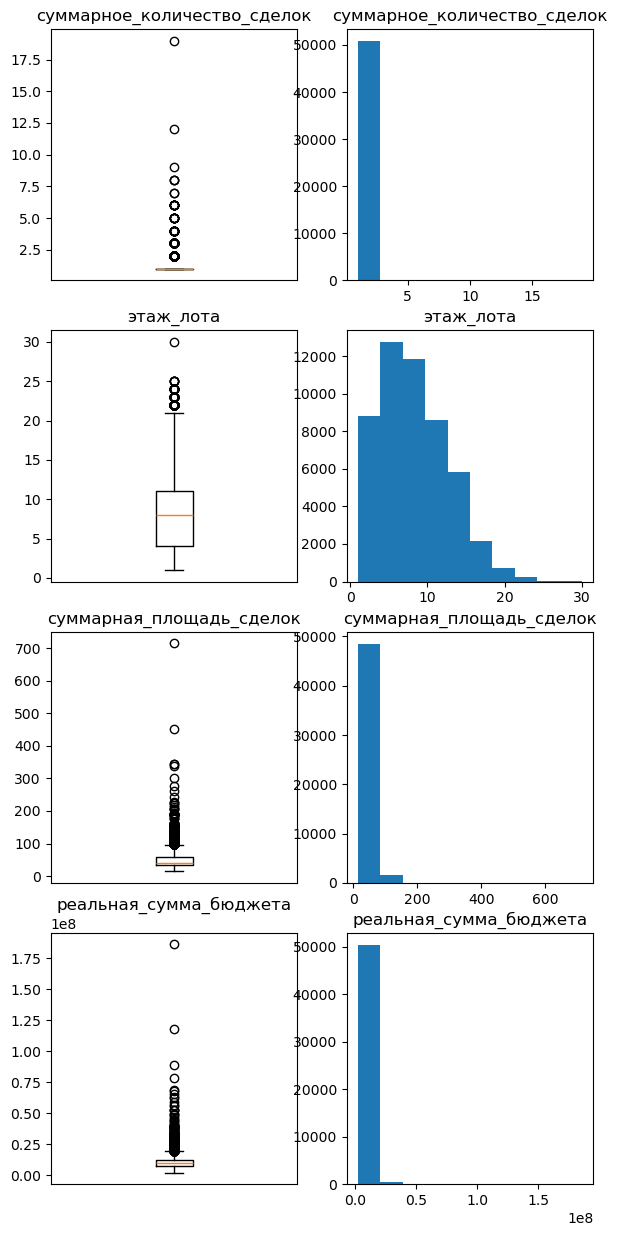

In [82]:
fig, axes = plt.subplots(deals_df.select_dtypes("number").columns.size - 2, 2)
axes = axes.flatten()
fig.set_size_inches(7, 15)
num_cols = deals_df.select_dtypes("number").columns.drop(["сумма_бюджета", "ипц"])

for i in range(0, num_cols.size * 2, 2):
    axes[i].boxplot(deals_df[num_cols[i // 2]].dropna())
    axes[i + 1].hist(deals_df[num_cols[i // 2]])
    axes[i].set_title(num_cols[i // 2])
    axes[i + 1].set_title(num_cols[i // 2])
    axes[i].tick_params(
        axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False)

plt.show()

Посмотрим теперь на значения в deals_df

In [83]:
deals_df[deals_df["суммарная_площадь_сделок"] > 150]["суммарное_количество_сделок"].value_counts()

суммарное_количество_сделок
2     14
6     11
5      7
4      5
3      4
8      3
1      3
7      2
9      1
12     1
19     1
Name: count, dtype: int64

In [84]:
deals_df[(deals_df["суммарная_площадь_сделок"] > 150) & (deals_df["суммарное_количество_сделок"] == 1)]["количество_комнат"].value_counts()

количество_комнат
4    3
Name: count, dtype: int64

Из этих данных делаем вывод, что большая суммарная площадь достигается за счет покупки сразу нескольких объектов, либо за счет того что сам объект большой (4х комнатная квартира)

Посмотрим на цены по районам и внутренней отделке, так как это одни из основных влияющих факторов

In [85]:
deals_df[deals_df["реальная_сумма_бюджета"] / deals_df["суммарная_площадь_сделок"] > 350_000]["район"].value_counts()

район
Коммунарка        499
Внуково            19
Филимонковский      2
Name: count, dtype: int64

In [86]:
deals_df[deals_df["реальная_сумма_бюджета"] / deals_df["суммарная_площадь_сделок"] > 350_000]["внутренняя_отделка"].value_counts()

внутренняя_отделка
Под чистовую и отделка как доп. опция                181
С отделкой                                           170
Без отделки                                           61
Под чистовую, с отделкой и отделка как доп. опция     42
Под чистовую                                          26
Под чистовую и с отделкой                             15
С отделкой, мебель как доп. опция                     10
С отделкой и мебелью                                   8
С отделкой и отделка как доп. опция                    3
Под чистовую и без отделки                             2
Отделка как доп. опция                                 2
Name: count, dtype: int64

In [87]:
deals_df.groupby("район").apply(lambda x: (x["реальная_сумма_бюджета"] / x["суммарная_площадь_сделок"]).mean(), include_groups=False).sort_values(ascending=False)

район
Коммунарка        245372.446148
Внуково           218638.265485
Щербинка          213857.032959
Троицк            213235.456625
Филимонковский    194710.253324
dtype: float64

In [88]:
deals_df[deals_df["реальная_сумма_бюджета"] / deals_df["суммарная_площадь_сделок"] > 350_000][deals_df[deals_df["реальная_сумма_бюджета"] / deals_df["суммарная_площадь_сделок"] > 350_000]["район"] == "Филимонковский"]["внутренняя_отделка"]

42441    С отделкой
42481    С отделкой
Name: внутренняя_отделка, dtype: object

Как видим, завышенные цены получаются из-за того, что квартиры находятся в более дорогих районах, а также за счет того что есть отделка

Все значения выбросов мы можем обосновать, поэтому не удаляем и не заменяем эти значения

Сохраняем чистые датасеты

In [89]:
projects_df.to_csv("clear_projects.csv", index=False)
deals_df.to_csv("clear_deals.csv", index=False)